# 50-D Multivariate Normal

This is a simple interactive version of the 100-D Multivariate Normal demo in the documentation.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(5)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems. Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems (efficiency "only" goes as $\propto 1/D$) using a 50-D highly correlated multivariate normal distribution.

In [4]:
ndim = 50  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

# ln(evidence)
lnz_truth = -ndim * np.log(20.)

For slice sampling, we want to scale both the number of live points and the update interval based on the number of dimensions. Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update_interval=5.*ndim,
                                bound='single', sample='slice', nlive=200, slices=5)
sampler.run_nested(dlogz=0.01, save_bounds=False)
res = sampler.results

iter: 33855+200 | bound: 829 | nc: 1 | ncall: 42104511 | eff(%):  0.081 | loglstar:   -inf < 14.796 <    inf | logz: -149.452 +/-  0.865 | dlogz:  0.000 >  0.010                

In [7]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update_interval=5.*ndim,
                                bound='single', sample='rslice', nlive=200, slices=ndim)
sampler.run_nested(dlogz=0.01, save_bounds=False)
res2 = sampler.results

iter: 34002+200 | bound: 169 | nc: 1 | ncall: 8496493 | eff(%):  0.403 | loglstar:   -inf < 16.040 <    inf | logz: -148.940 +/-  0.865 | dlogz:  0.000 >  0.010              

In [9]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, update_interval=8.*ndim,
                                bound='single', sample='hslice', nlive=200, slices=int(ndim/2))
sampler.run_nested(dlogz=0.01, save_bounds=False)
res3 = sampler.results

iter: 33864+200 | bound: 525 | nc: 1 | ncall: 42355056 | eff(%):  0.080 | loglstar:   -inf < 16.100 <    inf | logz: -148.195 +/-  0.862 | dlogz:  0.000 >  0.010                

Now let's see how we do.

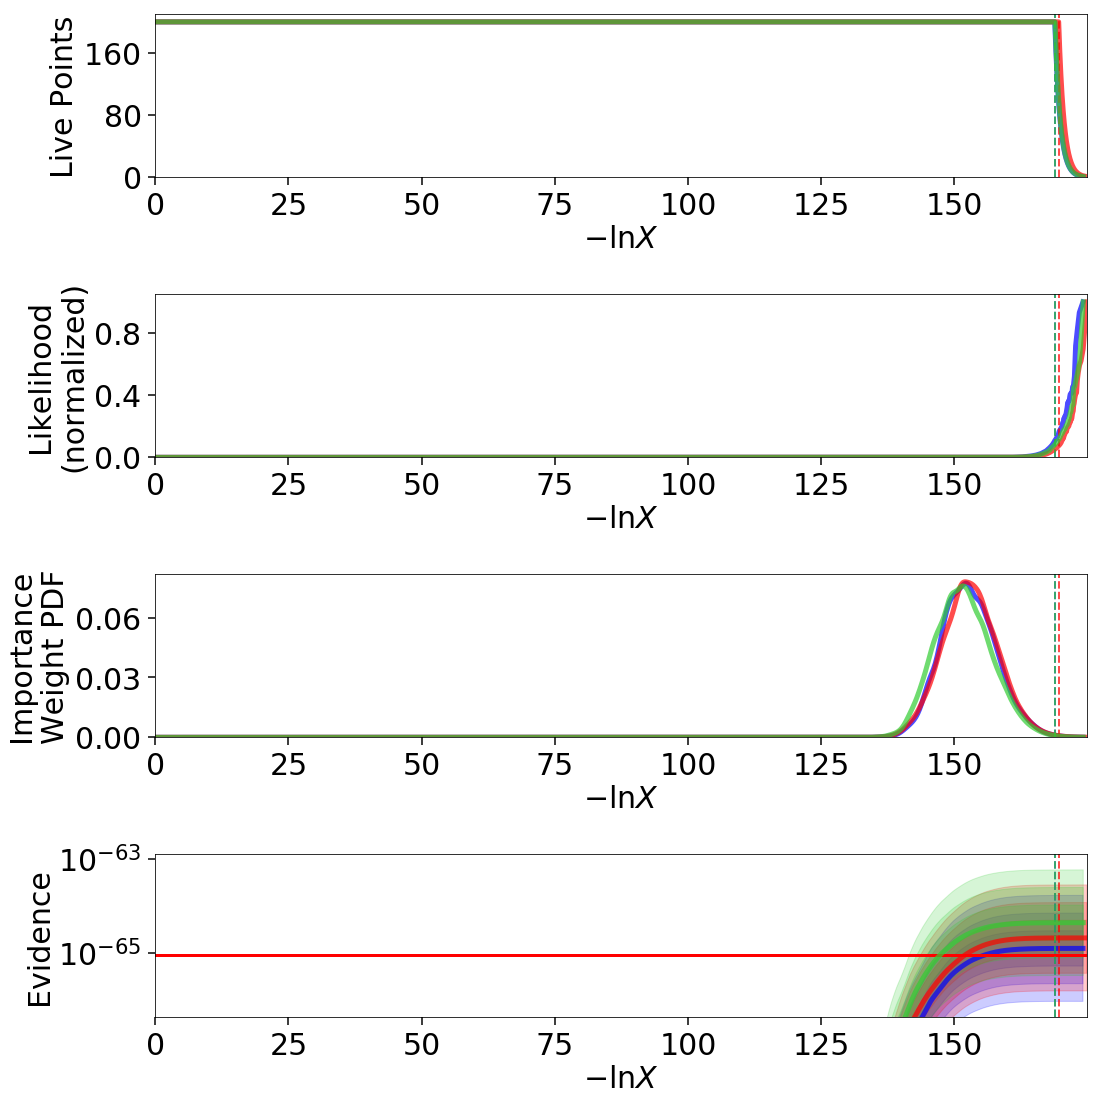

In [10]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, lnz_truth=lnz_truth, logplot=True)
fig, axes = dyplot.runplot(res2, color='red', logplot=True, fig=(fig, axes))
fig, axes = dyplot.runplot(res3, color='limegreen', logplot=True, fig=(fig, axes))
fig.tight_layout()